# Data Cleaning & Feature Engineering Pipeline  
### Housing Prices Dataset

This notebook presents a complete data cleaning pipeline:
- Data quality checks
- Outlier detection & winsorization
- Missing value treatment
- Categorical encoding
Ready for regression and classification models.


In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
# Acceso a carpeta y carga del archivo de funciones
import sys
sys.path.append('/content/drive/MyDrive/UCM/Documentación minería de datos y model predictiva20260120')

# Cargo funciones por ruta absoluta
#from NuestrasFunciones import *
execfile('/content/drive/MyDrive/UCM/Documentación minería de datos y model predictiva20260120/NuestrasFunciones.py')

In [5]:
import numpy as np
import pandas as pd


In [ ]:
!pip install missingno
!pip install feature_engine
!pip install pyarrow
!!pip install seaborn

['Requirement already satisfied: seaborn in /usr/local/lib/python3.12/dist-packages (0.13.2)',
 'Requirement already satisfied: numpy!=1.24.0,>=1.20 in /usr/local/lib/python3.12/dist-packages (from seaborn) (2.0.2)',
 'Requirement already satisfied: pandas>=1.2 in /usr/local/lib/python3.12/dist-packages (from seaborn) (2.2.2)',
 'Requirement already satisfied: matplotlib!=3.6.1,>=3.4 in /usr/local/lib/python3.12/dist-packages (from seaborn) (3.10.0)',
 'Requirement already satisfied: contourpy>=1.0.1 in /usr/local/lib/python3.12/dist-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (1.3.3)',
 'Requirement already satisfied: cycler>=0.10 in /usr/local/lib/python3.12/dist-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (0.12.1)',
 'Requirement already satisfied: fonttools>=4.22.0 in /usr/local/lib/python3.12/dist-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (4.61.1)',
 'Requirement already satisfied: kiwisolver>=1.3.1 in /usr/local/lib/python3.12/dist-packages (from matplotlib!=3.6.

## Estudio Descriptivo

In [6]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

# Lectura de datos
venta_viviendas = pd.read_excel('/content/drive/MyDrive/UCM/Documentación minería de datos y model predictiva20260120/Datos/VentaViviendas.xlsx')
venta_viviendas.head()


,year,month,price,Luxury,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,basement,yr_built,yr_renovated,lat,long
0,2014,7,653450,1,3,2.5,2070,-1,1.0,0,0,C,1540,1,1980,0,47.5936,-122.013
1,2014,6,710000,1,2,1.5,1640,-1,1.5,0,0,A,1540,1,1916,0,47.6624,-122.325
2,2014,10,780000,1,4,3.5,3720,-1,1.0,0,1,B,3720,0,2007,0,47.3216,-121.940
3,2014,12,795000,1,3,3.5,2260,-1,2.0,0,0,B,1880,1,2003,0,47.6422,-122.361
4,2014,10,399950,0,3,2.0,2050,-1,1.0,0,0,A,1170,1,1960,0,47.7447,-122.328


In [7]:
venta_viviendas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          5000 non-null   int64  
 1   month         5000 non-null   int64  
 2   price         5000 non-null   int64  
 3   Luxury        5000 non-null   int64  
 4   bedrooms      5000 non-null   int64  
 5   bathrooms     5000 non-null   float64
 6   sqft_living   5000 non-null   int64  
 7   sqft_lot      5000 non-null   int64  
 8   floors        5000 non-null   float64
 9   waterfront    5000 non-null   int64  
 10  view          5000 non-null   int64  
 11  condition     5000 non-null   object 
 12  sqft_above    5000 non-null   int64  
 13  basement      5000 non-null   int64  
 14  yr_built      5000 non-null   int64  
 15  yr_renovated  5000 non-null   int64  
 16  lat           5000 non-null   float64
 17  long          5000 non-null   float64
dtypes: float64(4), int64(13), ob

In [8]:
venta_viviendas.nunique()

,0
year,2
month,12
price,1709
Luxury,2
bedrooms,33
bathrooms,12
sqft_living,570
sqft_lot,3113
floors,6
waterfront,3


Posibles valores sospechosos:


*   bedrooms = 33: no es realista tener 33 valores distintos de cuartos
*   waterfront = 3: como es una variable binaria, debe contener maximo 2 valores unicos, lo que puede indicar un tercer valor erroneo (missing encubierto)
*   view, debe tratarse como categorica binaria
*   condition = 5: debe tener un valor sospechoso, debido a que se esperan categorias de la A a la D (4 valores unicos)
*   bathrooms = 12, No es imposible pero es mucho, puede ser por el float
*   sqft_lot = 3113, muchos valores y contiene valores (-1)
*   yr_renovated = 58, muchos valores deben ser 0 y pocos años reales de renovación. Además el ejercicio pide cambiarlo a binaria.
*   long = 602, tiene mucho menos valores unicos que lat, puede ser por redondeos distintos o precision desigual.










In [9]:
venta_viviendas['waterfront'].value_counts()

,count
waterfront,
0,4852
-1,106
1,42


Error en 106 observaciones, con valor (-1)

In [10]:
venta_viviendas['condition'].value_counts()

,count
condition,
B,3254
C,1289
A,412
?,40
D,5


 40 missings

In [11]:
venta_viviendas['bedrooms'].value_counts().sort_index()

,count
bedrooms,
0,4
1,42
2,671
3,2233
4,1592
5,357
6,58
7,8
8,3


Datos errones: valores irreales con frecuencias bajas. outliers reales o errores

In [12]:
venta_viviendas['bathrooms'].value_counts().sort_index()

,count
bathrooms,
0.0,129
1.0,933
1.5,317
2.0,1097
2.5,1623
3.0,463
3.5,302
4.0,74
4.5,44


Valores tipo float

In [13]:
venta_viviendas['yr_renovated'].value_counts().head(10)


,count
yr_renovated,
0,4784
2014,22
2004,11
1989,10
2005,9
2003,8
1986,8
2000,8
2009,7


4784 datos sin año de renovación. Perfecta para modificar como variable categorica binaria

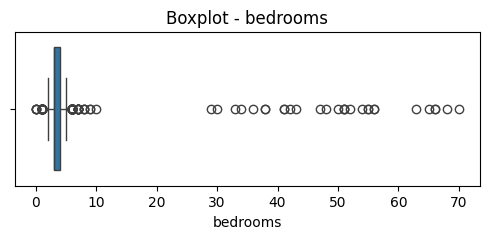

In [14]:
plt.figure(figsize=(6, 2))
sns.boxplot(x=venta_viviendas['bedrooms'])
plt.title('Boxplot - bedrooms')
plt.show()


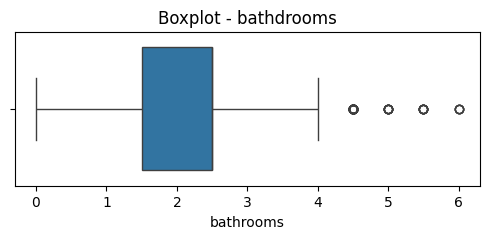

In [15]:
plt.figure(figsize=(6, 2))
sns.boxplot(x=venta_viviendas['bathrooms'])
plt.title('Boxplot - bathdrooms')
plt.show()


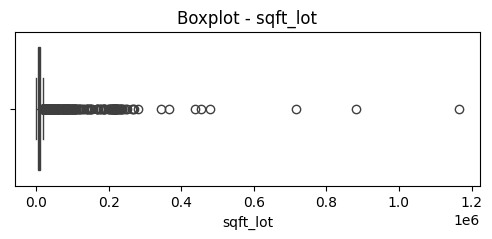

In [16]:
plt.figure(figsize=(6, 2))
sns.boxplot(x=venta_viviendas['sqft_lot'])
plt.title('Boxplot - sqft_lot')
plt.show()


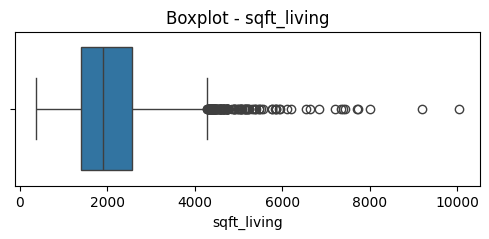

In [17]:
plt.figure(figsize=(6, 2))
sns.boxplot(x=venta_viviendas['sqft_living'])
plt.title('Boxplot - sqft_living')
plt.show()


In [18]:
skew_table = pd.DataFrame({
    'variable': ['bedrooms', 'bathrooms', 'sqft_lot', 'sqft_living'],
    'skew': [
        venta_viviendas['bedrooms'].skew(),
        venta_viviendas['bathrooms'].skew(),
        venta_viviendas['sqft_lot'].skew(),
        venta_viviendas['sqft_living'].skew()
    ]
})

skew_table['asimetria'] = skew_table['skew'].abs().apply(
    lambda x: 'Baja' if x < 1 else 'Alta'
)

skew_table




,variable,skew,asimetria
0,bedrooms,12.916180,Alta
1,bathrooms,0.035777,Baja
2,sqft_lot,13.051348,Alta
3,sqft_living,1.404513,Alta


Las variables presentan distintos grados de asimetría, lo que justifica el uso de métodos robustos para la detección y tratamiento de valores atípicos en aquellas con skew elevado


In [19]:
venta_viviendas.describe().round(1).T

,count,mean,std,min,25%,50%,75%,max
year,5000.0,2014.3,0.5,2014.0,2014.0,2014.0,2015.0,2015.0
month,5000.0,6.6,3.1,1.0,4.0,6.0,9.0,12.0
price,5000.0,544129.1,372986.9,86500.0,324937.5,451000.0,645000.0,7062500.0
Luxury,5000.0,0.4,0.5,0.0,0.0,0.0,1.0,1.0
bedrooms,5000.0,3.6,3.7,0.0,3.0,3.0,4.0,70.0
bathrooms,5000.0,2.1,0.9,0.0,1.5,2.5,2.5,6.0
sqft_living,5000.0,2077.4,916.5,370.0,1410.0,1910.0,2560.0,10040.0
sqft_lot,5000.0,13732.5,37581.4,-1.0,4500.0,7312.0,10284.2,1164794.0
floors,5000.0,1.5,0.5,1.0,1.0,1.5,2.0,3.5
waterfront,5000.0,-0.0,0.2,-1.0,0.0,0.0,0.0,1.0



*   **bedrooms**: asimetría extrema, valores > 10 no son realistas. Outliers severos. **Usar criterios(mediana/MAD), winsorizacion o truncado**
*   **bathrooms**: asimetría simétrica, distribución compacta. No se toca
*   **sqtf_lot**: outliers gigantes hasta 1.1 millones, asimetría extrema, media no representativa. Missing encubiertos (-1), valores extremos (parcelas enormes). **Candidata a winsorizar, transformación a log**.



# Gestion de Outliers

In [20]:
from NuestrasFunciones import gestiona_outliers

# Llamada en modo check
#venta_viviendas.select_dtypes(include=np.number).apply(lambda x: gestiona_outliers(x))#.set_index(['Low','up','Tot'])

#otra manera
outliers_df = venta_viviendas.select_dtypes(include=np.number) \
    .apply(lambda x: pd.Series(gestiona_outliers(x), index=['Low','Up','Tot'])).T

outliers_df
vars_a_tratar = ['price','bedrooms','bathrooms','sqft_living','sqft_lot']

outliers_df.loc[vars_a_tratar][outliers_df['Tot'] > 0]




year
month
price
Luxury
bedrooms
bathrooms
sqft_living
sqft_lot
floors
waterfront
view
sqft_above
basement
yr_built
yr_renovated
lat
long


/tmp/ipython-input-1131841277.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers_df.loc[vars_a_tratar][outliers_df['Tot'] > 0]


,Low,Up,Tot
price,0.0,1.94,1.94
bedrooms,0.0,0.60,0.60
bathrooms,0.0,0.08,0.08
sqft_living,0.0,0.28,0.28
sqft_lot,0.0,7.36,7.36


# Winsorizamos

In [21]:
venta_viviendas['bedrooms_w'] = gestiona_outliers(
    venta_viviendas['bedrooms'],
    clas='winsor'
)


bedrooms


In [22]:
venta_viviendas.loc[venta_viviendas['sqft_lot'] < 0, 'sqft_lot'] = np.nan


In [23]:
venta_viviendas['sqft_lot_w'] = gestiona_outliers(
    venta_viviendas['sqft_lot'],
    clas='winsor'
)


sqft_lot


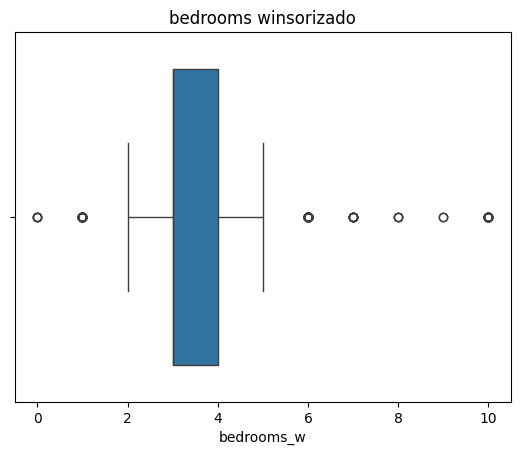

In [24]:
sns.boxplot(x=venta_viviendas['bedrooms_w'])
plt.title('bedrooms winsorizado')
plt.show()


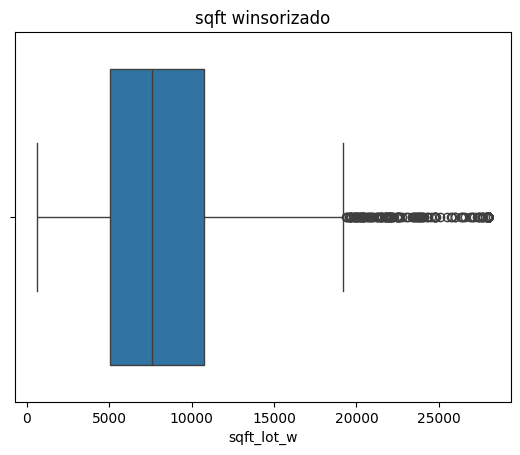

In [25]:
sns.boxplot(x=venta_viviendas['sqft_lot_w'])
plt.title('sqft winsorizado')
plt.show()


In [26]:
import numpy as np

venta_viviendas = venta_viviendas.replace({
    'waterfront': {-1: np.nan},
    'sqft_lot': {-1: np.nan},
    'condition': {'?': np.nan}
})


In [27]:
venta_viviendas.isna().sum()


,0
year,0
month,0
price,0
Luxury,0
bedrooms,0
bathrooms,0
sqft_living,0
sqft_lot,382
floors,0
waterfront,106


In [28]:
venta_viviendas.isna().sum(axis=1).head()


,0
0,2
1,2
2,2
3,2
4,2


In [29]:
venta_viviendas['n_missings'] = venta_viviendas.isna().sum(axis=1)


In [30]:
num_vars = venta_viviendas.select_dtypes(include=np.number).columns
num_vars = num_vars.drop('price')  # nunca imputamos el target

venta_viviendas[num_vars] = venta_viviendas[num_vars].apply(
    lambda x: x.fillna(x.median())
)


In [31]:
cat_vars = venta_viviendas.select_dtypes(include='object').columns

venta_viviendas[cat_vars] = venta_viviendas[cat_vars].apply(
    lambda x: x.fillna(x.mode()[0])
)


In [32]:
venta_viviendas.isna().sum()


,0
year,0
month,0
price,0
Luxury,0
bedrooms,0
bathrooms,0
sqft_living,0
sqft_lot,0
floors,0
waterfront,0


In [33]:
categoricas = ['condition', 'month', 'year']

venta_model = pd.get_dummies(
    venta_viviendas,
    columns=categoricas,
    drop_first=True
)


In [34]:
venta_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 33 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         5000 non-null   int64  
 1   Luxury        5000 non-null   int64  
 2   bedrooms      5000 non-null   int64  
 3   bathrooms     5000 non-null   float64
 4   sqft_living   5000 non-null   int64  
 5   sqft_lot      5000 non-null   float64
 6   floors        5000 non-null   float64
 7   waterfront    5000 non-null   float64
 8   view          5000 non-null   int64  
 9   sqft_above    5000 non-null   int64  
 10  basement      5000 non-null   int64  
 11  yr_built      5000 non-null   int64  
 12  yr_renovated  5000 non-null   int64  
 13  lat           5000 non-null   float64
 14  long          5000 non-null   float64
 15  bedrooms_w    5000 non-null   int64  
 16  sqft_lot_w    5000 non-null   float64
 17  n_missings    5000 non-null   int64  
 18  condition_B   5000 non-null 

In [35]:
venta_model.dtypes
venta_model.isna().sum().sum()


np.int64(0)

In [36]:
venta_model = venta_model.drop(columns=['bedrooms', 'sqft_lot'])
venta_model = venta_model.rename(columns={
    'bedrooms_w': 'bedrooms',
    'sqft_lot_w': 'sqft_lot'
})


In [39]:
venta_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         5000 non-null   int64  
 1   Luxury        5000 non-null   int64  
 2   bathrooms     5000 non-null   float64
 3   sqft_living   5000 non-null   int64  
 4   floors        5000 non-null   float64
 5   waterfront    5000 non-null   int64  
 6   view          5000 non-null   int64  
 7   sqft_above    5000 non-null   int64  
 8   basement      5000 non-null   int64  
 9   yr_built      5000 non-null   int64  
 10  yr_renovated  5000 non-null   int64  
 11  lat           5000 non-null   float64
 12  long          5000 non-null   float64
 13  bedrooms      5000 non-null   int64  
 14  sqft_lot      5000 non-null   float64
 15  n_missings    5000 non-null   int64  
 16  condition_B   5000 non-null   int64  
 17  condition_C   5000 non-null   int64  
 18  condition_D   5000 non-null 

In [37]:
bool_cols = venta_model.select_dtypes(include='bool').columns
venta_model[bool_cols] = venta_model[bool_cols].astype(int)


In [38]:
venta_model['waterfront'] = venta_model['waterfront'].astype(int)
